# Solving the Neutron Diffusion Equation:
## A Computational Journey Through Nuclear Reactors
### From One Dimension to Three-Dimensional Spherical Reactors with Reflective Boundary Conditions


#### One dimension in Carteasian coordinates with Dirichlet Boundary Condition 

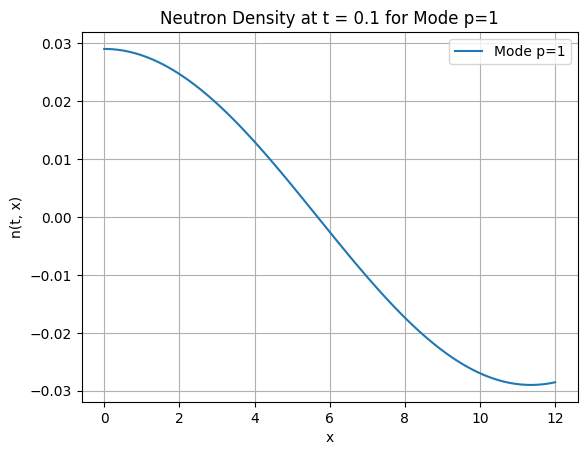

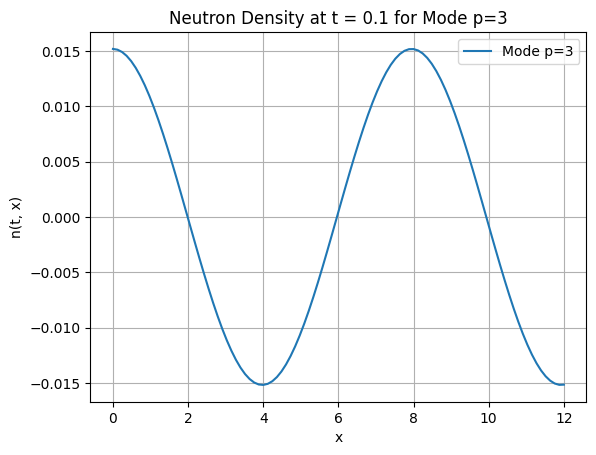

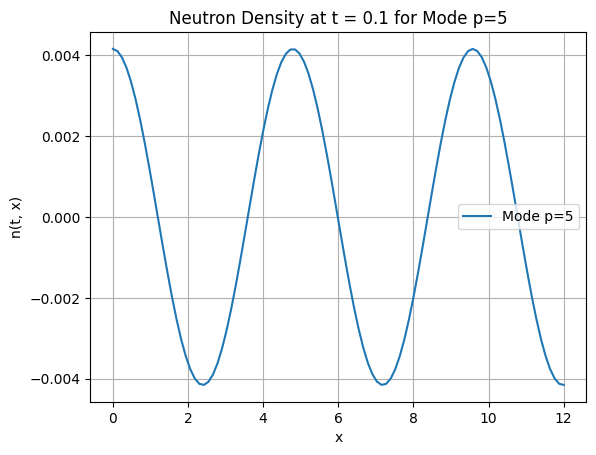

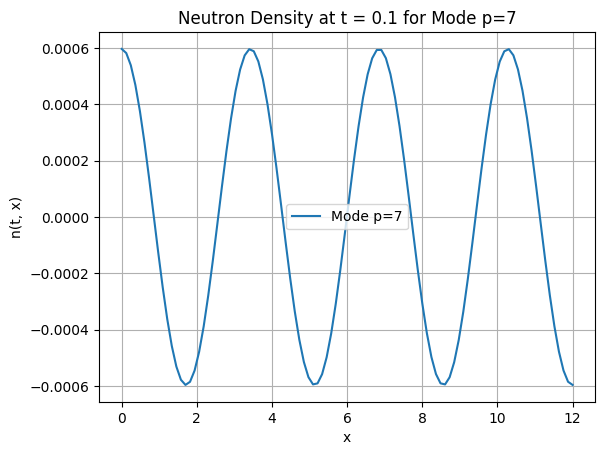

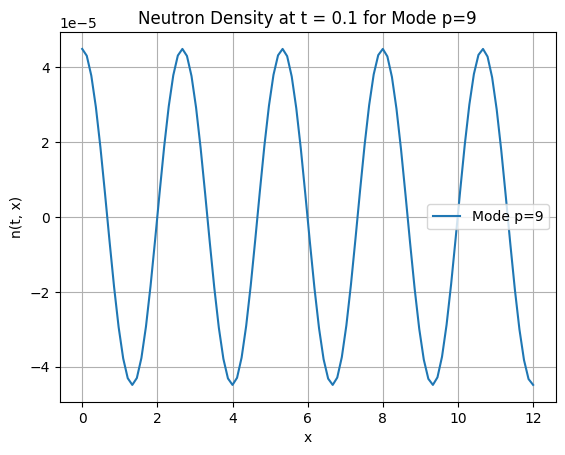

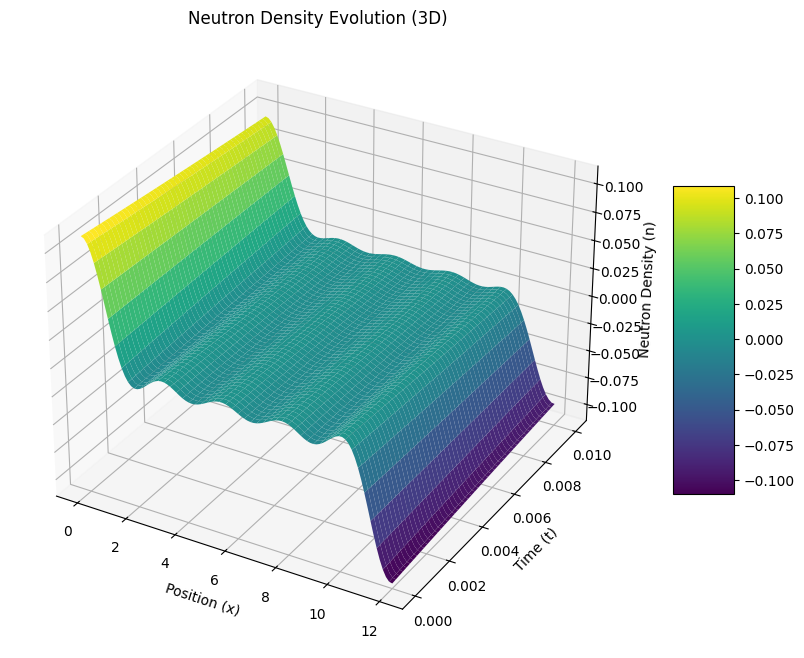

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define symbols
x, t, mu, eta, L, alpha = sp.symbols('x t mu eta L alpha')
n = sp.Function('n')(t, x)

# Define the diffusion equation
diff_eq = sp.Eq(n.diff(t) / n, mu * n.diff(x, 2) / n + eta)

# Define the T and X functions
T = sp.Function('T')(t)
X = sp.Function('X')(x)

# Manually define the separated equations
T_eq = sp.Eq(T.diff(t) / T, -alpha)
X_eq = sp.Eq(mu * X.diff(x, 2) / X + eta, -alpha)

# Simplify equations before solving
T_eq, X_eq = sp.simplify(T_eq), sp.simplify(X_eq)

# Solve the ODEs 
T_sol = sp.dsolve(T_eq, T)
X_sol = sp.dsolve(X_eq, X)

# Apply n(t, 0) = 0
X_sol = X_sol.subs(X_sol.args[1].subs(x, 0), 0)
# Apply n(t, L) = 0
X_sol = X_sol.subs(X_sol.args[1].subs(x, L), 0)

# Simplify solutions and extract the right-hand sides
T_sol, X_sol = sp.simplify(T_sol.rhs), sp.simplify(X_sol.rhs)

# Calculate the general solution
general_sol = T_sol * X_sol


# Specific solution parameters
mu_val = 10.0
eta_val = 0.08
L_val = 12.0
p_values = [1, 3, 5, 7, 9]
a_p_values = [0.1762, -0.1677, 0.1519, -0.1310, 0.1075] 

# Define time and space ranges for 3D plot
# Adjust time range to avoid numerical overflow
t_vals = np.linspace(0, 0.01, 50)  # Smaller time range (0 to 0.01)
x_vals = np.linspace(0, L_val, 100) 
t_val = 0.1  # Define t_val outside the loop

# Create meshgrid for 3D plotting
X, T = np.meshgrid(x_vals, t_vals)

# Calculate neutron density for each point in the meshgrid
Z = np.zeros_like(X)

# Loop over the modes
for i, p in enumerate(p_values):
    alpha_val = mu_val * (p * sp.pi / L_val)**2
    
    # Simplify the general solution with the current alpha value
    n_sol_simplified = sp.simplify(general_sol.subs(alpha, alpha_val))
    
    # Substitute values into the simplified solution
    n_sol = n_sol_simplified.subs({
        mu: mu_val, eta: eta_val, L: L_val, 
        sp.symbols('C1'): a_p_values[i],
        sp.symbols('C2'): 0
    })
    # Convert symbolic expression to a numerical function using lambdify
    # using numpy with 'sqrt' from numpy and handle negative arguments
    n_func = sp.lambdify((t, x), n_sol, modules=['numpy', {'sqrt': lambda arg: np.sqrt(arg + 0j) if arg < 0 else np.sqrt(arg)}]) 

    # Calculate neutron density values with overflow handling
    for j in range(len(t_vals)):
        for k in range(len(x_vals)):
            n_val = np.real(n_func(t_vals[j], x_vals[k]))
            # Check for NaN or infinite values and set to zero if encountered
            Z[j, k] += n_val if np.isfinite(n_val) else 0
    # 2D Plot for the current mode
    n_vals_2d = [np.real(n_func(t_val, xi)) for xi in x_vals]
    plt.figure()  # Create a new figure for each 2D plot
    plt.plot(x_vals, n_vals_2d, label=f'Mode p={p}')
    plt.xlabel('x')
    plt.ylabel('n(t, x)')
    plt.title(f'Neutron Density at t = {t_val} for Mode p={p}')
    plt.legend()
    plt.grid(True)
    plt.show()
 
 # 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, T, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Neutron Density (n)')
ax.set_title('Neutron Density Evolution (3D)')

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


### The 3D plot provides a comprehensive view of the neutron density evolution within the reactor. It reveals the dynamic interplay between diffusion (spreading), absorption, and the influence of the boundary conditions on the spatial and temporal behavior of the neutron population.


### 2-D case cartesian coordinates with Dirichlet BC


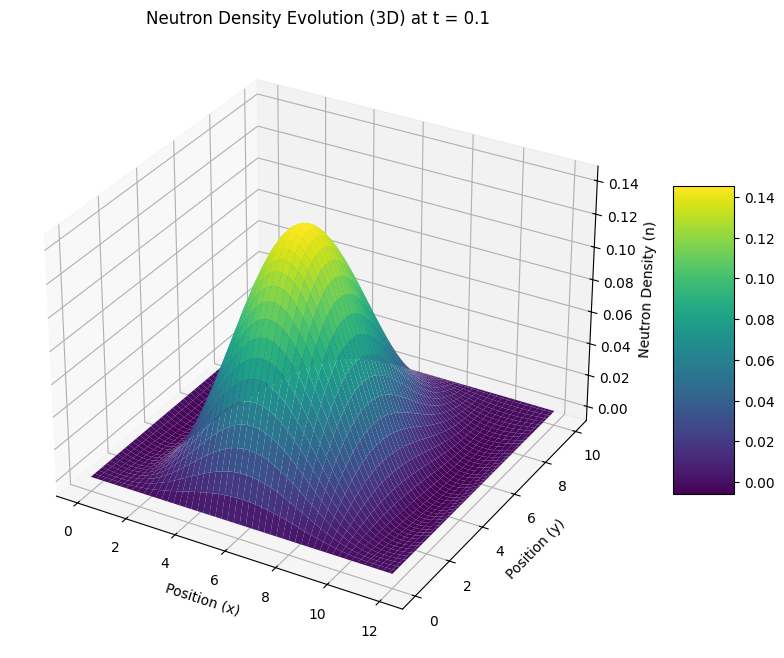

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define symbols
x, y, t, mu, eta, Lx, Ly, alpha = sp.symbols('x y t mu eta Lx Ly alpha')
n = sp.Function('n')(t, x, y)  # Neutron density function

# Define the T and X functions
T = sp.Function('T')(t)
X = sp.Function('X')(x)
Y = sp.Function('Y')(y)
# Define the diffusion equation
diff_eq = sp.Eq(n.diff(t), mu * (n.diff(x, 2) + n.diff(y, 2)) + eta * n)

# Substitute and rearrange the equation
substituted_eq = diff_eq.subs(n, T * X * Y)
separated_eq = substituted_eq.lhs / (T * X * Y) - substituted_eq.rhs / (T * X * Y)
separated_eq = sp.simplify(separated_eq)

#  isolate time and space dependent terms
time_term = separated_eq.coeff(sp.Derivative(T, t))  # Extract coefficient of dT/dt
space_term = separated_eq.subs(sp.Derivative(T, t), 0)  # Remove time-dependent term

# Create the separated equations with explicit derivatives
T_eq = sp.Eq(sp.Derivative(T, t), -alpha * T)  # Time-dependent ODE
X_eq = sp.Eq(sp.Derivative(X, x, 2), (-alpha / mu) * X)  # X-dependent ODE
Y_eq = sp.Eq(sp.Derivative(Y, y, 2), (-alpha / mu) * Y)  # Y-dependent ODE

# Solve the ODEs 
T_sol = sp.dsolve(T_eq, T)
X_sol = sp.dsolve(X_eq, X)
Y_sol = sp.dsolve(Y_eq, Y)

# Apply n(t, 0, y) = 0 and n(t, Lx, y) = 0
X_sol = X_sol.subs(X_sol.args[1].subs(x, 0), 0).subs(X_sol.args[1].subs(x, Lx), 0)
# Apply n(t, x, 0) = 0 and n(t, x, Ly) = 0
Y_sol = Y_sol.subs(Y_sol.args[1].subs(y, 0), 0).subs(Y_sol.args[1].subs(y, Ly), 0)

# Simplify solutions and extract the right-hand sides
T_sol, X_sol, Y_sol = sp.simplify(T_sol.rhs), sp.simplify(X_sol.rhs), sp.simplify(Y_sol.rhs)

# General solution
general_sol = T_sol * X_sol * Y_sol

# Specific solution parameters
mu_val = 10.0
eta_val = 0.08
Lx_val = 12.0
Ly_val = 10.0
p_values = [1, 3]  
q_values = [1, 2]
a_pq_values = [[0.1, 0.05],
               [-0.08, -0.03]]  # Example coefficient values

# Define a specific solution for a finite number of modes
n_sol = 0
for p in p_values:
    for q in q_values:
        alpha1_val = mu_val * (p * sp.pi / Lx_val)**2
        alpha2_val = mu_val * (q * sp.pi / Ly_val)**2
        alpha = alpha1_val + alpha2_val
        n_sol += a_pq_values[p_values.index(p)][q_values.index(q)] * sp.exp((eta_val - alpha)*t) * sp.sin(p*sp.pi*x/Lx_val) * sp.sin(q*sp.pi*y/Ly_val)

# Define time and space ranges
t_val = 0.1
x_vals = np.linspace(0, Lx_val, 100)
y_vals = np.linspace(0, Ly_val, 100)

# Create meshgrid for 3D plotting
X, Y = np.meshgrid(x_vals, y_vals)

# --- 3D Plotting Code ---

# Calculate neutron density for all modes at once (more efficient)
Z = sp.re(n_sol.subs({t: t_val, mu: mu_val, eta: eta_val, Lx: Lx_val, Ly: Ly_val})).evalf()

# Convert Z to a NumPy array for plotting
Z_vals = np.array([[Z.subs({x: xi, y: yi}) for xi in x_vals] for yi in y_vals], dtype=np.float64)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z_vals, cmap='viridis')

# Add labels and title
ax.set_xlabel('Position (x)')
ax.set_ylabel('Position (y)')
ax.set_zlabel('Neutron Density (n)')
ax.set_title('Neutron Density Evolution (3D) at t = {}'.format(t_val))

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


### - The 3D plot provides a visual representation of the neutron density distribution within the reactor at a specific time, revealing the influence of different modes and the boundary conditions.



## 3-D case cartesian coordinates with Dirichlet BC

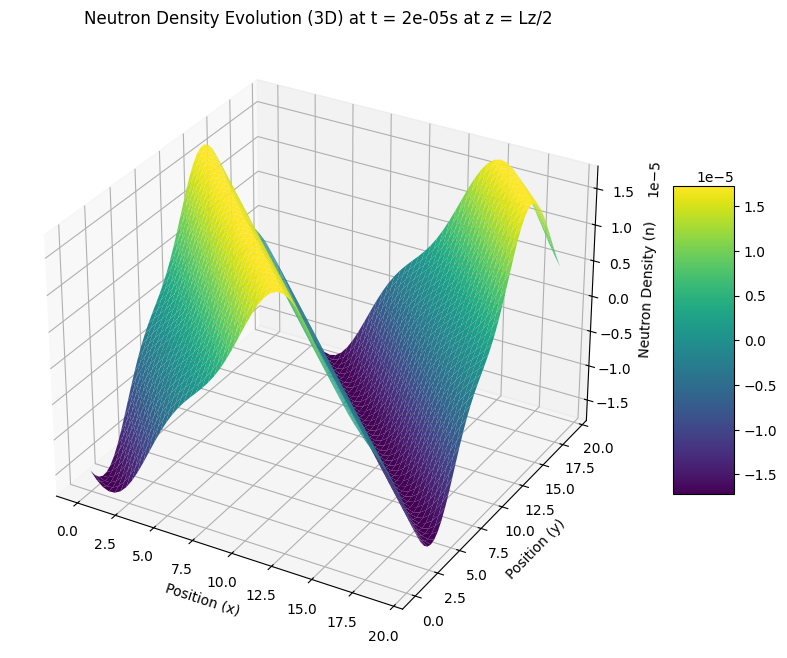

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define symbols
x, y, z, t, mu, eta, Lx, Ly, Lz, alpha = sp.symbols('x y z t mu eta Lx Ly Lz alpha')
n = sp.Function('n')(t, x, y, z)

# Define T, X, Y, Z functions
T = sp.Function('T')(t)
X = sp.Function('X')(x)
Y = sp.Function('Y')(y)
Z = sp.Function('Z')(z)

# Define the diffusion equation
diff_eq = sp.Eq(n.diff(t), mu * (n.diff(x, 2) + n.diff(y, 2) + n.diff(z, 2)) + eta * n)

# Substitute and rearrange the equation manually
substituted_eq = diff_eq.subs(n, T * X * Y * Z)
separated_eq = substituted_eq.lhs / (T * X * Y * Z) - substituted_eq.rhs / (T * X * Y * Z)
separated_eq = sp.simplify(separated_eq)

# Manually isolate time and space dependent terms
time_term = separated_eq.coeff(T.diff(t))  # Extract coefficient of dT/dt
space_term = separated_eq.subs(T.diff(t), 0)  # Remove time-dependent term

# Create the separated equations with explicit derivatives
T_eq = sp.Eq(T.diff(t), -alpha * T)  # Time-dependent ODE
X_eq = sp.Eq(X.diff(x, 2), (-alpha / mu) * X)  # X-dependent ODE
Y_eq = sp.Eq(Y.diff(y, 2), (-alpha / mu) * Y)  # Y-dependent ODE
Z_eq = sp.Eq(Z.diff(z, 2), (-alpha / mu) * Z)  # Z-dependent ODE

# Solve the ODEs
T_sol = sp.dsolve(T_eq, T)
X_sol = sp.dsolve(X_eq, X)
Y_sol = sp.dsolve(Y_eq, Y)
Z_sol = sp.dsolve(Z_eq, Z)

# Apply boundary conditions
X_sol = X_sol.subs(X_sol.args[1].subs(x, 0), 0).subs(X_sol.args[1].subs(x, Lx), 0)
Y_sol = Y_sol.subs(Y_sol.args[1].subs(y, 0), 0).subs(Y_sol.args[1].subs(y, Ly), 0)
Z_sol = Z_sol.subs(Z_sol.args[1].subs(z, 0), 0).subs(Z_sol.args[1].subs(z, Lz), 0)

# Simplify solutions and extract the right-hand sides
T_sol, X_sol, Y_sol, Z_sol = sp.simplify(T_sol.rhs), sp.simplify(X_sol.rhs), sp.simplify(Y_sol.rhs), sp.simplify(Z_sol.rhs)

# General solution
general_sol = T_sol * X_sol * Y_sol * Z_sol

mu_val = 10.0
eta_val = 0.08
Lx_val = 19.14  # cm
Ly_val = Lx_val  # cm (symmetric case)
Lz_val = Lx_val  # cm (symmetric case)
t_val = 0.000020  # 20 microseconds

# Define p, q, and r values 
p_values = [1, 3, 5]
q_values = [1, 3, 5]
r_values = [1, 3, 5]

a_pqr_values = [
    [
        [0.0623, 0, 0.0295],
        [0, 0, 0],
        [-0.0295, 0, 0.0138],
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
    ],
    [
        [-0.0295, 0, 0.0138],
        [0, 0, 0],
        [0.0138, 0, 0.0064]
    ]
]

# Grid parameters 
num_points_x = 50
num_points_y = 50
num_points_z = 50

# Define time and space ranges for 3D plot
x_vals = np.linspace(0, Lx_val, num_points_x)
y_vals = np.linspace(0, Ly_val, num_points_y)
z_vals = np.linspace(0, Lz_val, num_points_z)

# Create meshgrid for 3D plotting (only for x and y)
X, Y, Z_axis = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')

# Create a function to calculate neutron density
def calc_neutron_density(x_vals, y_vals, z_vals, t_val):
    Z = np.zeros((num_points_x, num_points_y, num_points_z), dtype=np.float64)
    for i, p in enumerate(p_values):
        for j, q in enumerate(q_values):
            for k, r in enumerate(r_values):
                alpha1_val = mu_val * (p * np.pi / Lx_val)**2
                alpha2_val = mu_val * (q * np.pi / Ly_val)**2
                alpha3_val = mu_val * (r * np.pi / Lz_val)**2
                alpha_val = alpha1_val + alpha2_val + alpha3_val
                
                n_sol_mode = general_sol.subs({
                    mu: mu_val, eta: eta_val, Lx: Lx_val, Ly: Ly_val, Lz: Lz_val,
                    sp.symbols('C1'): a_pqr_values[i][j][k],
                    sp.symbols('C2'): 0,  # Assuming C2 is zero for this example
                    alpha: alpha_val 
                }).evalf()

                n_func = sp.lambdify((t, x, y, z), n_sol_mode, modules=['numpy'])

                for xi in range(num_points_x):
                    for yi in range(num_points_y):
                        for zi in range(num_points_z):
                            Z[xi, yi, zi] += np.real(n_func(t_val, x_vals[xi], y_vals[yi], z_vals[zi]))
    return Z

# Calculate neutron density for all modes at once (more efficient)
Z_vals = calc_neutron_density(x_vals, y_vals, z_vals, t_val)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X[:, :, 25], Y[:, :, 25], Z_vals[:, :, 25], cmap='viridis')  # Plot a slice at z = Lz/2 for better visualization

# Add labels and title
ax.set_xlabel('Position (x)')
ax.set_ylabel('Position (y)')
ax.set_zlabel('Neutron Density (n)')
ax.set_title('Neutron Density Evolution (3D) at t = {}s at z = Lz/2'.format(t_val))

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


### We're looking at a cross-section at the reactor's mid-height, at a specific time. Higher density is concentrated near the center, gradually decreasing towards the edges, where it reaches zero due to the Dirichlet boundary conditions 

### Cylindrical coordinates

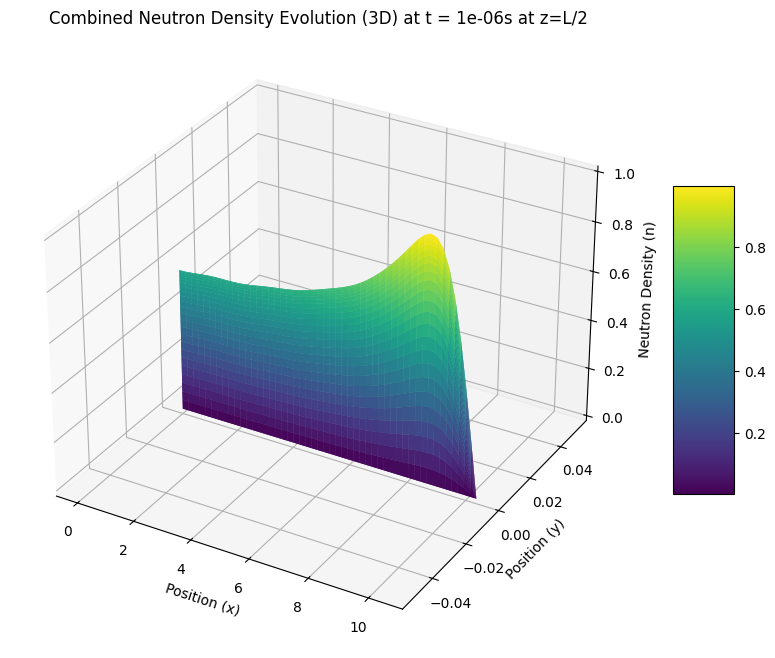

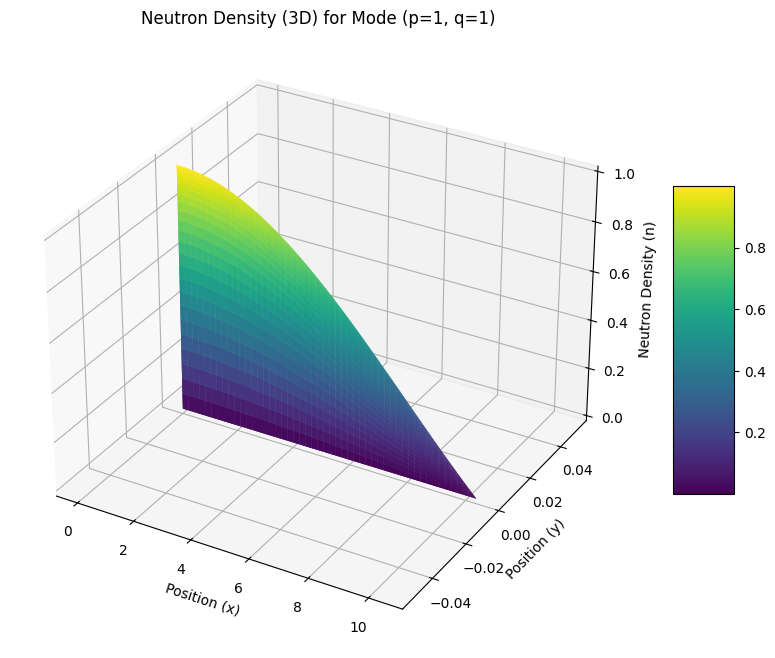

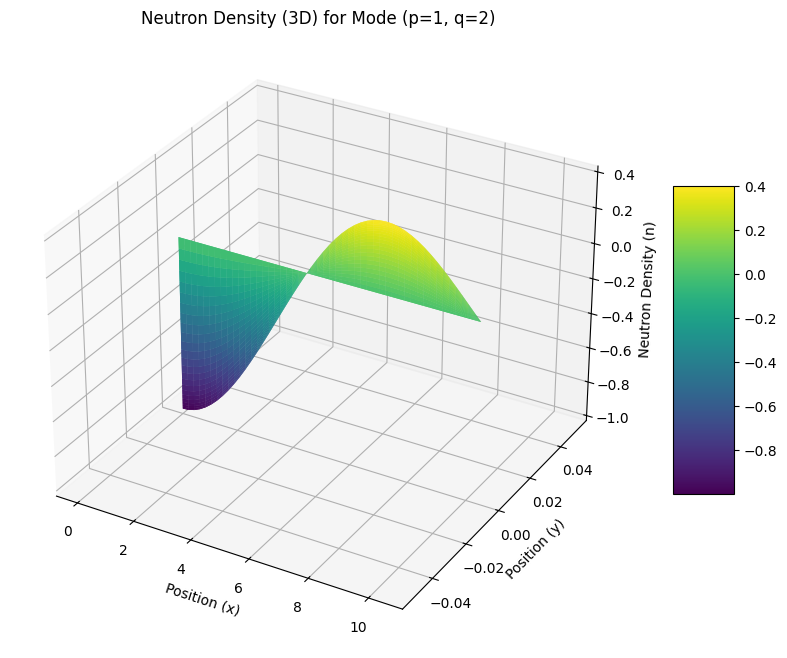

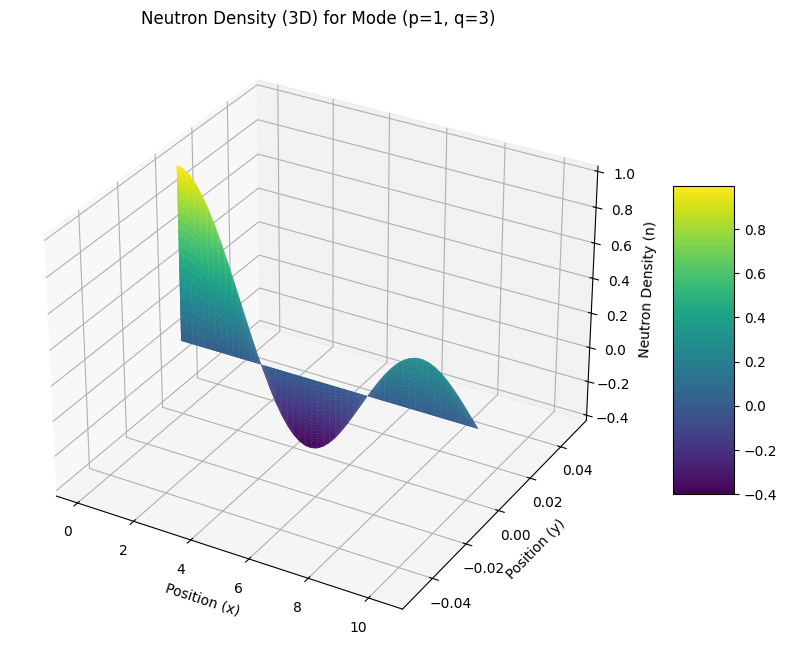

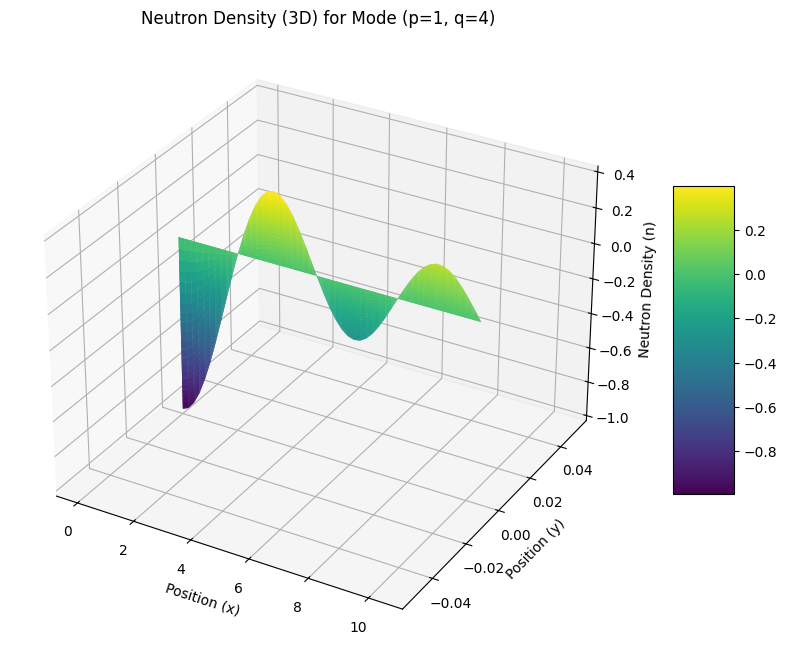

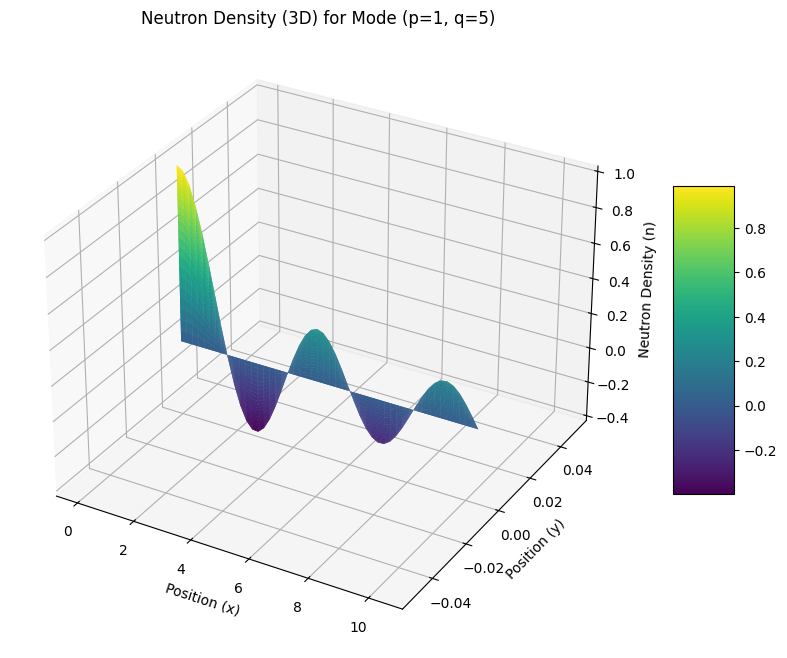

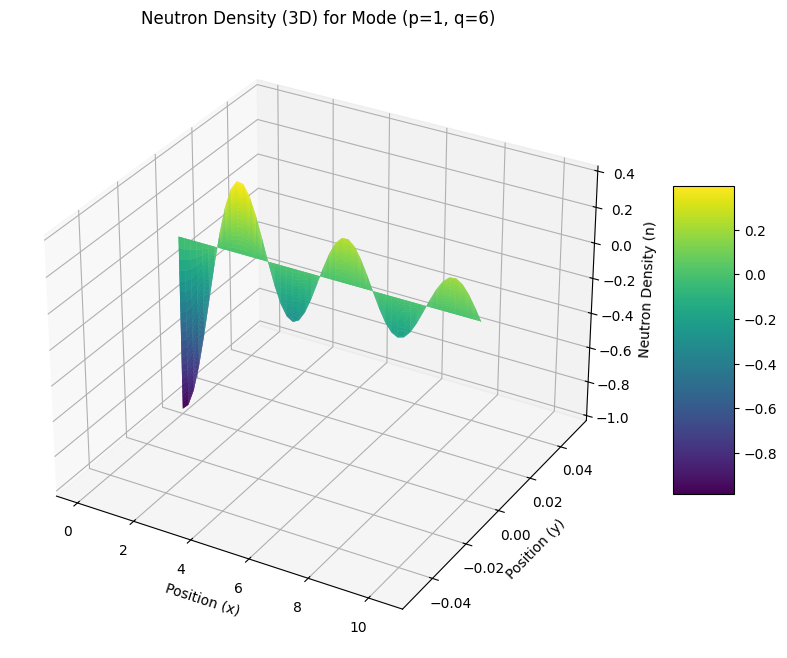

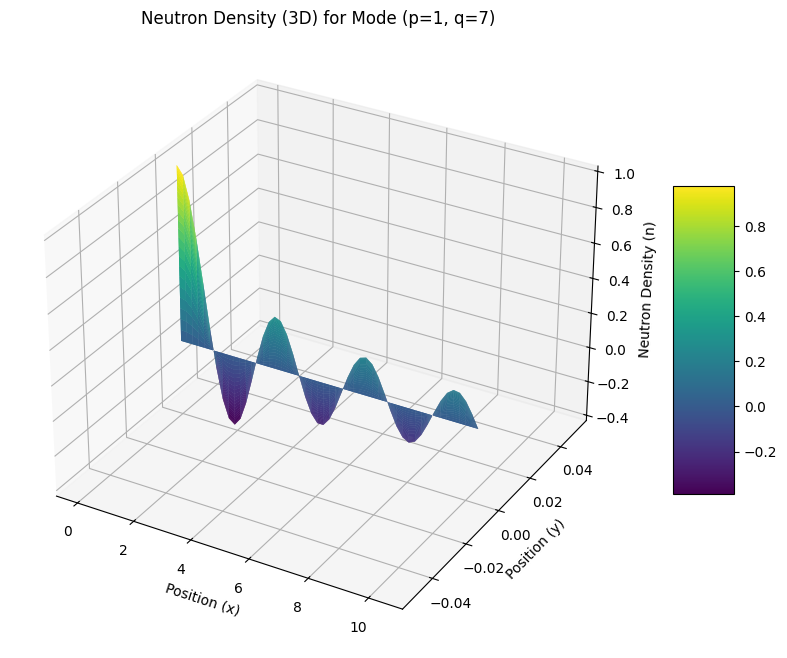

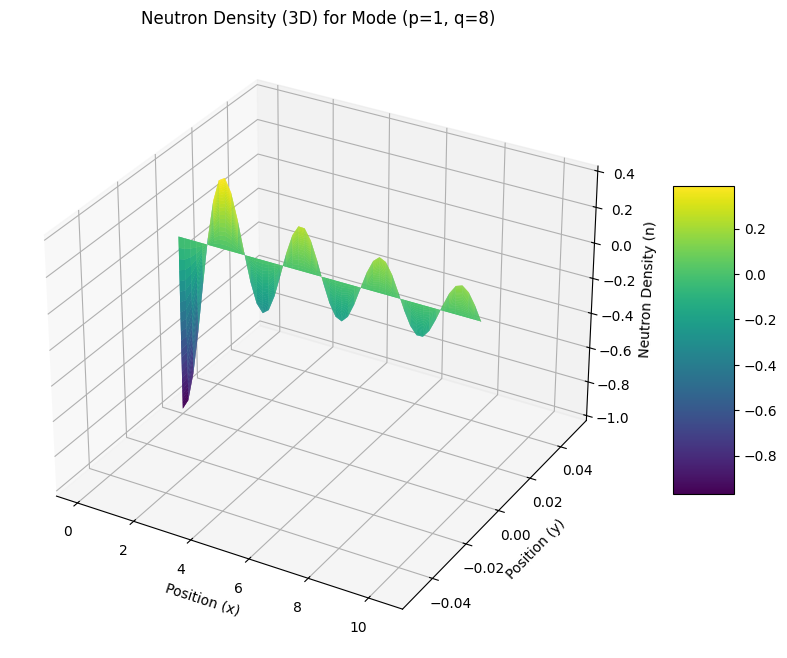

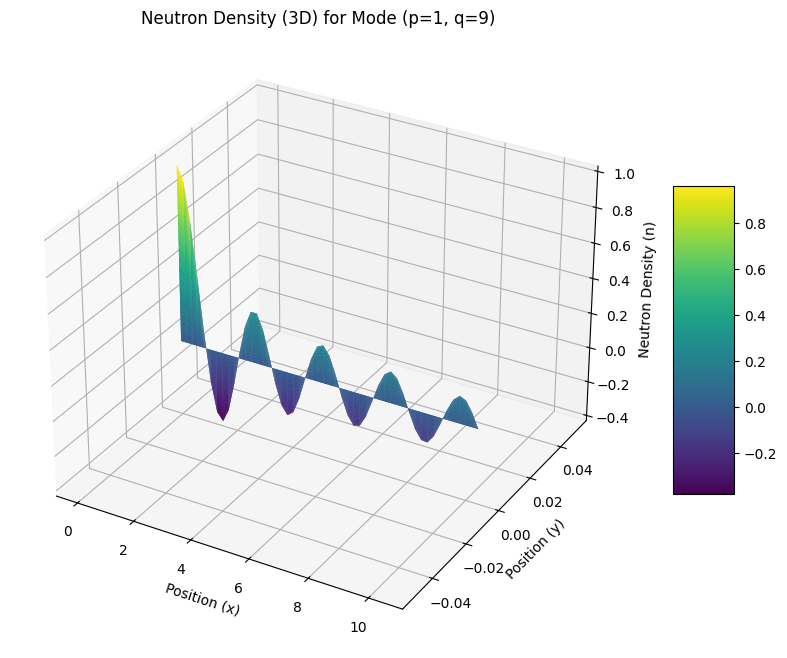

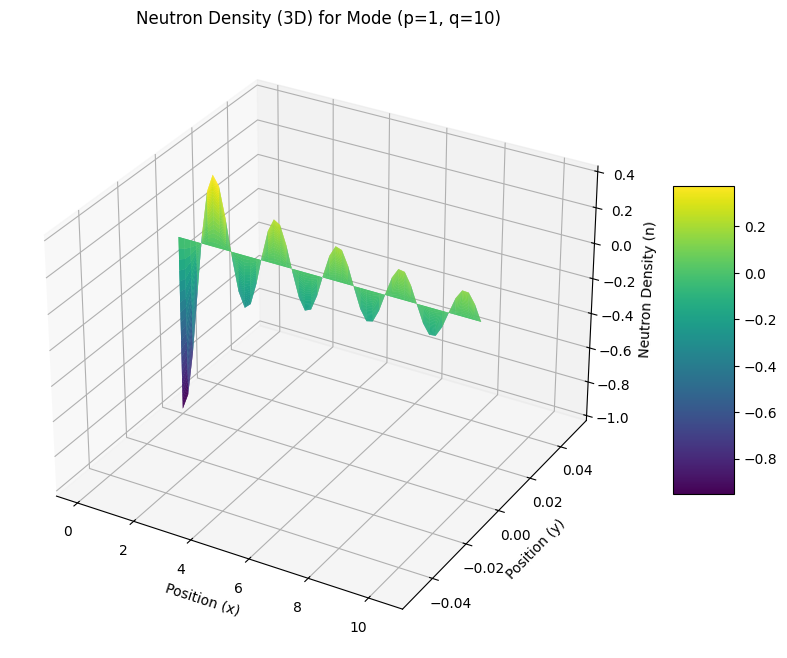

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import j0, jn_zeros

# Define constants and parameters
mu_val = 2.3446e5  # cm^2/s
eta_val = 1.8958e8  # 1/s
r1_val = 10.36  # cm
L_val = 19.14  # cm
t_val = 1e-6  # 1 microsecond

# Define p and q values
p_values = [1]  # Only fundamental axial mode (p=1) is considered
q_values = np.arange(1, 11)  # First 10 radial modes

# Coefficient values from Table 3
a_pq_values = [0.2244, -0.2150, 0.1958, -0.1708, 0.1428, -0.1143, 0.0878, -0.0648, 0.0463, -0.0323]

# Bessel function zeros
alpha_q_values = jn_zeros(0, len(q_values))  # First 10 zeros of J0

# Define the radial solution R(r)
def R_sol(r, alpha_q, r1):
    return j0((alpha_q / r1) * r)

# Define the axial solution Z(z)
def Z_sol(z, p, L):
    return np.sin(p * np.pi * z / L)

# Define the general solution n(t, r, z)
def neutron_density(t, r, z, p_values, q_values, alpha_q_values, a_pq_values, mu, eta, r1, L):
    density = np.zeros_like(r, dtype=np.float64)
    
    for p in p_values:
        for idx, q in enumerate(q_values):
            alpha_q = alpha_q_values[q - 1]
            a_pq = a_pq_values[q - 1]
            exponent = eta - mu * ((alpha_q / r1)**2 + (np.pi / L)**2)
            
            # Prevent overflow by capping the exponent value
            exp_term = np.exp(np.clip(exponent * t, -700, 700))
            
            term = a_pq * R_sol(r, alpha_q, r1) * Z_sol(z, p, L) * exp_term
            density += term
    
    return density

# Define time and space ranges for 3D plot
r_vals = np.linspace(0, r1_val, 50)
z_vals = np.linspace(0, L_val, 50)

# Create meshgrid for 3D plotting (only for r and z)
R, Z = np.meshgrid(r_vals, z_vals)

# Calculate neutron density for all modes at once (more efficient)
Z_vals_combined = np.array([[neutron_density(t_val, ri, zi, p_values, q_values, alpha_q_values, a_pq_values, mu_val, eta_val, r1_val, L_val)
                             for ri in r_vals] for zi in z_vals], dtype=float)  # Ensure dtype is float

# Check if there are any NaN values and replace them with zeros for plotting
Z_vals_combined = np.nan_to_num(Z_vals_combined, nan=0.0, posinf=1.0, neginf=-1.0)

# Normalize Z_vals for better visualization
Z_vals_combined /= (np.max(np.abs(Z_vals_combined)) + 1e-10)  # Avoid division by zero

# Create 3D plot for combined neutron density
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
X = R * np.cos(0)  
Y = R * np.sin(0)
surf = ax.plot_surface(X, Y, Z_vals_combined, cmap='viridis')

# Add labels and title
ax.set_xlabel('Position (x)')
ax.set_ylabel('Position (y)')
ax.set_zlabel('Neutron Density (n)')
ax.set_title(f'Combined Neutron Density Evolution (3D) at t = {t_val}s at z=L/2')

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Evaluate and plot each mode separately
for p in p_values:
    for q in q_values:
        alpha_q = alpha_q_values[q - 1]
        a_pq = a_pq_values[q - 1]
        exponent = eta_val - mu_val * ((alpha_q / r1_val)**2 + (np.pi / L_val)**2)
        exp_term = np.exp(np.clip(exponent * t_val, -700, 700))
        n_sol = a_pq * j0((alpha_q / r1_val) * R) * np.sin(p * np.pi * Z / L_val) * exp_term
        Z_vals = n_sol
        
        # Normalize Z_vals for better visualization
        Z_vals /= (np.max(np.abs(Z_vals)) + 1e-10)  # Avoid division by zero

        # Create 3D plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        X = R * np.cos(0)  
        Y = R * np.sin(0)
        surf = ax.plot_surface(X, Y, Z_vals, cmap='viridis')

        # Add labels and title
        ax.set_xlabel('Position (x)')
        ax.set_ylabel('Position (y)')
        ax.set_zlabel('Neutron Density (n)')
        ax.set_title(f'Neutron Density (3D) for Mode (p={p}, q={q})')

        # Add a colorbar
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()


#### The plot visualizes the neutron density distribution within a cylindrical reactor at a specific time (t = 1e-06 seconds) and at the mid-height plane (z = Lz/2).at a fixed azimuthal angle. so to grasp the first graph better  to clarify the behavior of the neutron density distribution! Plotting each mode separately helps to isolate their individual contributions and understand how they combine to form the overall pattern in the first graph

### the neutron diffusion equation in spherical reactor with Dirichlet Boundary condition

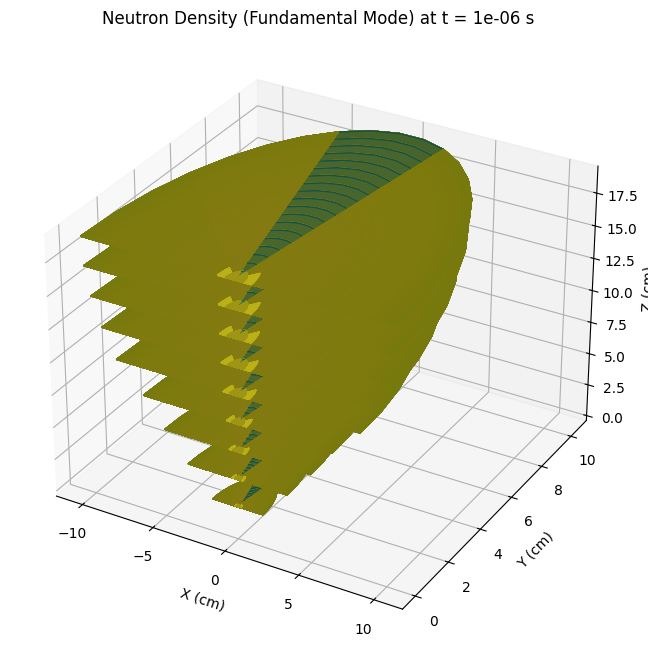

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import jv, jn_zeros
from matplotlib.colors import LogNorm
# Constants
mu_val = 2.3446e5  # cm^2/s
eta_val = 1.8958e8  # 1/s
r1_val = 10.36  # cm
L_val = 19.14  # cm
t_val = 1e-6  # s

# Fundamental Mode (p=1, q=1)
p = 1
q = 1

# Coefficient value (original, unscaled)
a_pq = 0.6717e8  # From Table 3

# Bessel function zero
alpha_q = jn_zeros(0, 1)[0]  # First zero of J0

# Define space ranges for 3D plot (Reduced resolution)
r_vals = np.linspace(0, r1_val, 20)
z_vals = np.linspace(0, L_val, 20)
phi_vals = np.linspace(0, np.pi, 20)  
theta_vals = np.linspace(0, np.pi/2, 20)  

# Create meshgrid
R, Z, PHI, THETA = np.meshgrid(r_vals, z_vals, phi_vals, theta_vals, indexing='ij')

# Calculate neutron density with exponential term
alpha_p = mu_val * (p * np.pi / r1_val)**2
exponent = (eta_val - alpha_p) * t_val  
bessel_component = jv(0, (alpha_q / r1_val) * R)
sine_component = np.sin(p * np.pi * Z / L_val)
exp_component = np.exp(exponent)
N_vals = a_pq * bessel_component * sine_component * exp_component

# Normalize for opacity (use log scale for better visualization)
epsilon = 1e-10  # Small value to avoid log(0)
N_vals_normalized = np.log(N_vals + epsilon) 
N_vals_normalized = (N_vals_normalized - N_vals_normalized.min()) / (N_vals_normalized.max() - N_vals_normalized.min())

# Convert from spherical to cartesian coordinates
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
Z = R * np.cos(THETA)

# Create a figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface (Corrected to use 2D slices)
# Extract 2D slices along the Z-axis at different depths
for z_slice in np.linspace(0, L_val, 10): 
    idx = np.argmin(np.abs(z_vals - z_slice))  # Find nearest index to the slice
    X_slice = X[:, :, :, idx]
    Y_slice = Y[:, :, :, idx]
    N_slice = N_vals_normalized[:, :, :, idx]

    # Reshape to 2D explicitly for plot_surface
    X_slice = X_slice.reshape(X_slice.shape[0], -1) 
    Y_slice = Y_slice.reshape(Y_slice.shape[0], -1)
    N_slice = N_slice.reshape(N_slice.shape[0], -1)

    # Ensure Z is 2D
    Z_slice = z_slice * np.ones_like(X_slice)  
    ax.plot_surface(X_slice, Y_slice, Z_slice, facecolors=cm.viridis(LogNorm()(N_slice)), alpha=0.5)

ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_title(f'Neutron Density (Fundamental Mode) at t = {t_val} s')

plt.show()


#### The plot showcases the neutron density distribution within a spherical reactor, specifically focusing on the fundamental mode (p=1, q=1) at a particular time ( t_val = 1e-6seconds).The plot depicts a half-sphere, showing the expected radial symmetry of the fundamental mode. The color gradient, transitioning from yellow (high density) at the center to blue (low density) at the edges, visually represents the exponential decay of neutron density as you move away from the center.

### solving the neutron diffusion equation in the 3D case in the spherical reactor but this time with Neumann Boundary conditions


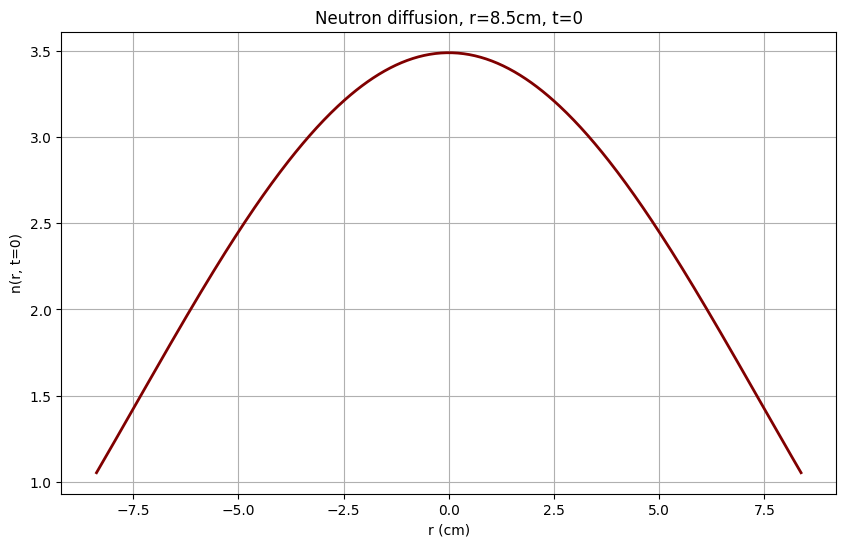

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
mu_val = 2.3446e5  # cm^2/s
eta_val = 1.8958e8  # 1/s
lambda_t = 0.01  # example value for transport free path
r1_val = 8.369  # critical radius
t_val = 1e-6  # s
alpha_val = -4.401e7  # example separation constant
k_val = 0.2809  # corresponding k value

# Neutron density function
def neutron_density(t, r, A=12.415):
    return A * np.exp(-alpha_val * t) * np.sin(k_val * r) / r

# Radial distance values
r_vals = np.linspace(-r1_val, r1_val, 500)

# Compute neutron density
n_vals = neutron_density(0, r_vals)

# Plot the initial condition
plt.figure(figsize=(10, 6))
plt.plot(r_vals, n_vals, color='maroon', linewidth=2)
plt.xlabel('r (cm)')
plt.ylabel('n(r, t=0)')
plt.title('Neutron diffusion, r=8.5cm, t=0')
plt.grid(True)
plt.show()


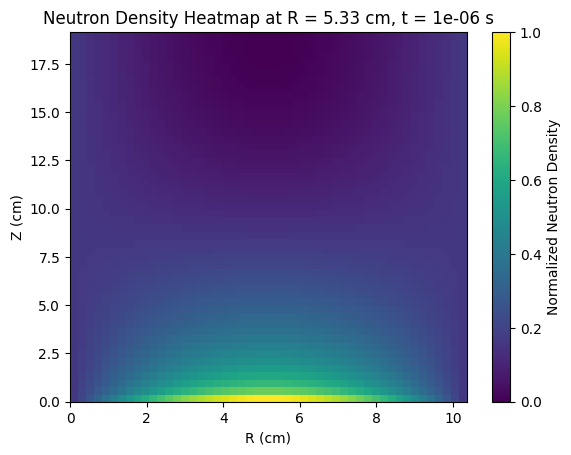

In [1]:
import numpy as np
import plotly.graph_objects as go
from scipy.special import jv, yv, jn_zeros, jvp, yvp
import matplotlib.pyplot as plt

# Constants
mu_val = 2.3446e5  # cm^2/s
eta_val = 1.8958e8  # 1/s
r1_val = 10.36  # cm
L_val = 19.14  # cm
t_val = 1e-6  # s

# Fundamental Mode (p=1, q=1)
p = 1
q = 1

# Coefficient value (original, unscaled)
a_pq = 0.6717e8  # From Table 3

# Bessel function properties
def bessel_derivative(x, l, k):
    B_over_A = -jv(l, x) / yv(l, x)
    return jvp(l, x) + B_over_A * yvp(l, x)

# Find the zero of the derivative (first zero for fundamental mode)
alpha_q = jn_zeros(0, 1)[0]  

# Meshgrid with finer resolution
r_vals = np.linspace(0.1, r1_val, 50)
z_vals = np.linspace(0, L_val, 50)
phi_vals = np.linspace(0, 2 * np.pi, 40)

# Create meshgrid
R, Z, PHI = np.meshgrid(r_vals, z_vals, phi_vals, indexing='ij')

# Calculate neutron density with exponential term
scaling_factor = 1e-7 # Scaling factor 
alpha_p = mu_val * (p * np.pi / r1_val)**2
exponent = (eta_val - alpha_p) * t_val * scaling_factor

B_over_A = -jv(1, alpha_q) / yv(1, alpha_q)
radial_component = jv(0, (alpha_q / r1_val) * R) + B_over_A * yv(0, (alpha_q / r1_val) * R)
angular_component = np.sin(p * np.pi * Z / L_val) * np.ones_like(PHI)
N_vals = a_pq * radial_component * angular_component * np.exp(exponent)

# Normalize for opacity (use linear scale)
N_vals_normalized = (N_vals - N_vals.min()) / (N_vals.max() - N_vals.min())

# Average over phi angles to get a 2D array
N_vals_2d = np.mean(N_vals_normalized, axis=2)

# Display a heatmap of the N_vals_2d at r=r1_val/2
r_slice_index = int(N_vals_2d.shape[0] // 2)
plt.imshow(N_vals_2d, origin='lower', cmap='viridis', aspect='auto', extent=[0, r1_val, 0, L_val])
plt.colorbar(label='Normalized Neutron Density')
plt.xlabel('R (cm)')
plt.ylabel('Z (cm)')
plt.title(f'Neutron Density Heatmap at R = {r_vals[r_slice_index]:.2f} cm, t = {t_val} s')
plt.show()

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=R[:, :, 0],
    y=Z[:, :, 0],
    z=N_vals_normalized[:, :, 0],
    colorscale='Viridis'
)])

fig.update_layout(
    title='3D Neutron Density Distribution',
    scene=dict(
        xaxis_title='R (cm)',
        yaxis_title='Z (cm)',
        zaxis_title='Normalized Neutron Density'
    )
)

fig.show()


#### this 3D plot provides a visual representation of how the neutron density is distributed within a spherical reactor at a specific time, highlighting the dominance of the fundamental mode and the impact of the Neumann boundary condition.